In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 8.6MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 194kB 19.1MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

# A fastai Learner from Scratch

## Data

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [5]:
t = get_image_files(path)
t[0]

Path('/root/.fastai/data/imagenette2-160/val/n03417042/n03417042_12711.JPEG')

In [6]:
from glob import glob
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('/root/.fastai/data/imagenette2-160/val/n03417042/n03417042_12711.JPEG')

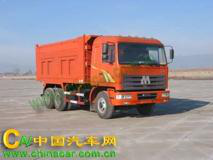

In [7]:
im = Image.open(files[0])
im

In [8]:
%timeit Image.open(files[0])

The slowest run took 13.79 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 186 µs per loop


In [9]:
%timeit PILImage.create(files[0])

1000 loops, best of 5: 779 µs per loop


In [10]:
im_t = tensor(im)
im_t.shape

torch.Size([160, 213, 3])

In deeplearning.ai, and tensorflow the shape is like this. But for Pytorch channl comes first.

In [11]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n03417042','n03888257','n03425413','n01440764','n03394916','n03028079','n03000684','n03445777','n02979186','n02102040']

In [12]:
v2i = lbls.val2idx(); v2i

{'n01440764': 3,
 'n02102040': 9,
 'n02979186': 8,
 'n03000684': 6,
 'n03028079': 5,
 'n03394916': 4,
 'n03417042': 0,
 'n03425413': 2,
 'n03445777': 7,
 'n03888257': 1}

### Dataset

In [13]:
class Dataset:
    def __init__(self, fns): 
      self.fns=fns
    def __len__(self): 
      return len(self.fns)
    def __getitem__(self, i): 
      """
      evertime an index is passed to Dataset instance, this will be called
      probablyhow oliveier didi the compute
      """
      im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
      y = v2i[self.fns[i].parent.name]
      return tensor(im).float()/255, tensor(y) # will return tuple of x and y

Find all train and valid files

In [14]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)

(9469, 3925)

In [15]:
train

(#9469) [Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_10563.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_27085.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_7335.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_23566.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_7506.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_4238.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_8298.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_1214.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/ILSVRC2012_val_00047189.JPEG'),Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_5768.JPEG')...]

In [16]:
ttt = Dataset(train)
ttt

In [17]:
ttt[0][1] # is y label. x is ttt[0][0]

tensor(0)

In [18]:
train_ds,valid_ds = Dataset(train),Dataset(valid)

In [19]:
x,y = train_ds[0]
x.shape,y

(torch.Size([64, 64, 3]), tensor(0))

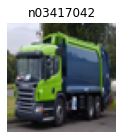

In [20]:
show_image(x, title=lbls[y]);

In [21]:
len(train_ds[0])

2

In [22]:
def collate(idxs, ds): 
    """ take dataset ds of certain idxs and stack them as batches"""
    xb,yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb),torch.stack(yb)

In [23]:
x,y = collate([1,2], train_ds)
x.shape,y

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

In [24]:
L.range(train_ds)

(#9469) [0,1,2,3,4,5,6,7,8,9...]

In [26]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
      self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): 
      return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        """https://docs.python.org/3/reference/datamodel.html#object.__iter__"""
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        # make batches
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)
            # function, variables

In [27]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

In [28]:
stats = [xb.mean((0,1,2)),xb.std((0,1,2))]
stats

[tensor([0.4739, 0.4676, 0.4482]), tensor([0.2730, 0.2718, 0.2960])]

In [30]:
class Normalize:
    def __init__(self, stats): 
      self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device) # move to whichever device stats is stored in
        return (x-self.stats[0])/self.stats[1]

In [31]:
norm = Normalize(stats)
def tfm_x(x): return norm(x).permute((0,3,1,2))

In [32]:
t = tfm_x(x)
t.mean((0,2,3)),t.std((0,2,3)) # dont mean across channels

(tensor([0.2177, 0.2498, 0.2030]), tensor([0.8673, 0.8572, 0.8105]))

In [33]:
t.shape

torch.Size([2, 3, 64, 64])

## Module and Parameter

In [34]:
Tensor._make_subclass

<function _TensorBase._make_subclass>

2 required positional argument: "cls", "data"

In [35]:
class Parameter(Tensor):
    def __new__(self, x): 
      return Tensor._make_subclass(Parameter, x, True) # register a subclass Parameter
    def __init__(self, *args, **kwargs): 
      self.requires_grad_()

In [36]:
Parameter(tensor(3.))

tensor(3., requires_grad=True)

In [37]:
class Module:
    """ this is a template Module function, whcih can be used to make loss or learner """
    def __init__(self):
        self.hook,self.params,self.children,self._training = None,[],[],False
        
    def register_parameters(self, *ps): 
      self.params += ps
    def register_modules   (self, *ms): 
      self.children += ms
        
    @property
    def training(self): # context manager
      return self._training

    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: 
          m.training=v
            
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        """ if children are inheriting parameter or module, register them"""
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)
        
    def __call__(self, *args, **kwargs):
        """what gets called"""
        res = self.forward(*args, **kwargs)
        if self.hook is not None: 
          self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): 
          p.data = p.data.cuda()

In [39]:
class ConvLayer(Module):
    """ make weights bias and set acts"""
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w) # initialize the weights properly
    
    def forward(self, x):
        """ forwartd pass for conv laler"""
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        if self.act: x = F.relu(x)
        return x

Check size of params

In [41]:
l = ConvLayer(3, 4)
len(l.parameters())

2

In [42]:
xbt = tfm_x(xb) # normalize
r = l(xbt)
r.shape

torch.Size([128, 4, 64, 64])

In [46]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni)) # nf is no of nodes/filters it has to learn, ni is no of inputs 
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w) # inizialize weights properly
    
    def forward(self, x): return x@self.w.t() + self.b

In [47]:
l = Linear(4,2)
r = l(torch.ones(3,4))
r.shape

torch.Size([3, 2])

In [49]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.c,self.l = ConvLayer(3,4),Linear(4,2) #combining two layers

In [50]:
t = T()
len(t.parameters())

4

In [51]:
t.cuda()
t.l.w.device

device(type='cuda', index=0)

### Simple CNN

In [61]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers) # Module

    def forward(self, x):
        for l in self.layers: 
          x = l(x) # apply the later 
        return x

In [62]:
class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

In [63]:
def simple_cnn():
    return Sequential(
        ConvLayer(3 ,16 ,stride=2), #32 size of the pixel now 
        ConvLayer(16,32 ,stride=2), #16 size
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

In [64]:
m = simple_cnn()
len(m.parameters())

10

In [102]:
def print_stats(outp, inp): print (outp.mean().item(),outp.std().item())
for i in range(4): m.layers[i].hook = print_stats

r = m(xbt)
r.shape

0.44144207239151 0.796753466129303
0.5309522151947021 0.8325068950653076
0.4574553072452545 0.7485754489898682
0.4136667847633362 0.694685161113739


torch.Size([128, 10])

hook to print layer activation shapes

In [71]:
def print_act_shape(outp, inp): print(inp[0].shape,'-->',outp.shape) # 0 xs

In [70]:
for i in range(4): 
  m.layers[i].hook = print_act_shape

r=m(xbt)

torch.Size([128, 3, 64, 64]) --> torch.Size([128, 16, 32, 32])
torch.Size([128, 16, 32, 32]) --> torch.Size([128, 32, 16, 16])
torch.Size([128, 32, 16, 16]) --> torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8]) --> torch.Size([128, 128, 4, 4])


## Loss

In [72]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [73]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

sm = log_softmax(r); sm[0][0]

tensor(-2.5533, grad_fn=<AliasBackward>)

In [74]:
loss = nll(sm, yb)
loss

tensor(2.9504, grad_fn=<AliasBackward>)

In [75]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
sm = log_softmax(r); sm[0][0]

tensor(-2.5533, grad_fn=<AliasBackward>)

In [76]:
x = torch.rand(5)
a = x.max()
x.exp().sum().log() == a + (x-a).exp().sum().log()

tensor(True)

In [77]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

logsumexp(r)[0]

tensor(2.8613, grad_fn=<AliasBackward>)

In [78]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [79]:
sm = log_softmax(r); sm[0][0]

tensor(-2.5533, grad_fn=<AliasBackward>)

In [83]:
def cross_entropy(preds, yb): return nll(log_softmax(preds), yb).mean()

## Learner

In [84]:
class SGD:
    def __init__(self, params, lr, wd=0.): store_attr()
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()

In [86]:
train_dl

Dataloaders is just calling Dataloader to make a tuple

In [87]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

In [88]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr()
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')
    
    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

### Callbacks

In [89]:
class Callback(GetAttr): _default='learner'

In [90]:
class SetupLearnerCB(Callback):
    """ call back to normalize before batch"""
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb),yb

    def before_fit(self): self.model.cuda()

In [91]:
class TrackResults(Callback):
    def before_epoch(self): 
        self.accs,self.losses,self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc)
        n = len(xb) 
        self.losses.append(self.loss*n)
        self.ns.append(n)

In [92]:
cbs = [SetupLearnerCB(),TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1116628933889534 0.23085859119231175


0 False 2.0689393411624204 0.23261146496815285


### Scheduling the Learning Rate

In [93]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6
        
    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10:# or torch.isnan(self.loss): 
          raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

In [94]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)
# got cancelled probbaly due to nan

0 True 2.474732515313127 0.1137395712324427


0 False 2.2708287718949043 0.10929936305732484


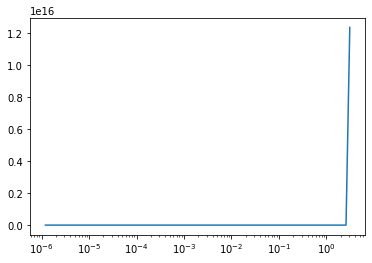

In [95]:
plt.plot(lrfind.lrs[:-2],lrfind.losses[:-2])
plt.xscale('log')

In [96]:
class OneCycle(Callback):
    def __init__(self, base_lr): self.base_lr = base_lr
    def before_fit(self): self.lrs = []

    def before_batch(self):
        if not self.model.training: return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start,div_start = 0.25,10
        if pct<pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)

In [97]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])

In [ ]:
learn.fit(8)

0 True 2.2247939823371 0.17171823846235082


0 False 2.1265684713375794 0.20178343949044586


1 True 2.0720789550110887 0.2501848136022811


1 False 2.0194996516719743 0.29146496815286627


2 True 1.9857635771992819 0.29168866828598583


2 False 1.9266423666401273 0.3207643312101911


3 True 1.8814204162926391 0.3448093779702186


3 False 1.837914261544586 0.3610191082802548


In [ ]:
plt.plot(onecyc.lrs);

## Conclusion

## Questionnaire

> tip: Experiments: For the questions here that ask you to explain what some function or class is, you should also complete your own code experiments.

1. What is `glob`?
1. How do you open an image with the Python imaging library?
1. What does `L.map` do?
1. What does `Self` do?
1. What is `L.val2idx`?
1. What methods do you need to implement to create your own `Dataset`?
1. Why do we call `convert` when we open an image from Imagenette?
1. What does `~` do? How is it useful for splitting training and validation sets?
1. Does `~` work with the `L` or `Tensor` classes? What about NumPy arrays, Python lists, or pandas DataFrames?
1. What is `ProcessPoolExecutor`?
1. How does `L.range(self.ds)` work?
1. What is `__iter__`?
1. What is `first`?
1. What is `permute`? Why is it needed?
1. What is a recursive function? How does it help us define the `parameters` method?
1. Write a recursive function that returns the first 20 items of the Fibonacci sequence.
1. What is `super`?
1. Why do subclasses of `Module` need to override `forward` instead of defining `__call__`?
1. In `ConvLayer`, why does `init` depend on `act`?
1. Why does `Sequential` need to call `register_modules`?
1. Write a hook that prints the shape of every layer's activations.
1. What is "LogSumExp"?
1. Why is `log_softmax` useful?
1. What is `GetAttr`? How is it helpful for callbacks?
1. Reimplement one of the callbacks in this chapter without inheriting from `Callback` or `GetAttr`.
1. What does `Learner.__call__` do?
1. What is `getattr`? (Note the case difference to `GetAttr`!)
1. Why is there a `try` block in `fit`?
1. Why do we check for `model.training` in `one_batch`?
1. What is `store_attr`?
1. What is the purpose of `TrackResults.before_epoch`?
1. What does `model.cuda` do? How does it work?
1. Why do we need to check `model.training` in `LRFinder` and `OneCycle`?
1. Use cosine annealing in `OneCycle`.

### Further Research

1. Write `resnet18` from scratch (refer to <<chapter_resnet>> as needed), and train it with the `Learner` in this chapter.
1. Implement a batchnorm layer from scratch and use it in your `resnet18`.
1. Write a Mixup callback for use in this chapter.
1. Add momentum to SGD.
1. Pick a few features that you're interested in from fastai (or any other library) and implement them in this chapter.
1. Pick a research paper that's not yet implemented in fastai or PyTorch and implement it in this chapter.
  - Port it over to fastai.
  - Submit a pull request to fastai, or create your own extension module and release it. 
  - Hint: you may find it helpful to use [`nbdev`](https://nbdev.fast.ai/) to create and deploy your package.